# Decoding the rythms of emotion: 
### A sentimental journey through music genres

Afonso Cadete | 20211519 <br>
Bruna Faria | 20211529 <br>
Inês Vieira | 20211589 <br>
Rita Centeno | 20211579 <br>

### Table of Contents
1. [Text Preprocessing](#tp)
2. [Modeling](#model)
3. [Sentiment Analysis](#sa)

## **Text Preprocessing**
<a id='tp'></a>

1. [Library Imports](#libraries-imports)
2. [Dataset: First Impressions](#first-impressions)
3. [Exploratory Data Analysis](#eda)
4. [Text Preprocessing](#preproc)

### Library Imports
<a id='libraries-imports'></a>

In [1]:
# STANDARD LIBRARIES
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import csv

# VISUALIZATIONS
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

# NLTK
# !pip install -U nltk
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('vader_lexicon')
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
# !pip install vaderSentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# SCIKIT-LEARN
# !pip install -U scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV#, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
# from sklearn.neighbors import KNeighborsClassifier

# XGBOOST
# !pip install xgboost
from xgboost import XGBClassifier

# KERAS
# !pip install keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
# !pip install -U keras-tuner
import kerastuner as kt

# SENTIMENT ANALYSIS
from nrclex import NRCLex
# !pip install textblob
from textblob import TextBlob

# OTHER
import math
import statistics
from scipy.stats import pearsonr

from operator import itemgetter

import gc

import warnings
warnings.filterwarnings('ignore')

from path import path

# FUNCTIONS
from utils import *

%load_ext autoreload
%autoreload 2

C:\Users\ritaf\AppData\Local\Temp\ipykernel_21556\1947845245.py:50: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### Dataset: First Impressions
<a id='first-impressions'></a>

In [2]:
# Import Data 
train_data = pd.read_csv(path + 'data_updated\\train.csv', index_col=-1)
test_data = pd.read_csv(path + 'data_updated\\test.csv', index_col=-1).sort_index()
sample_submission = pd.read_csv(path + 'data_updated\\sample_submission.csv', index_col='id').sort_index()

In [3]:
train = train_data.copy()
test = test_data.copy()
data = pd.concat([train, test], axis=0)
train

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
535805,Walk Away,rock,Tony Molina,2013,699,{},When you said you loved me\nDid you mean it th...
7519483,Gotta Make It Kid Naruto Rap,rap,Reece Lett,2021,4,{Sl!ck},Kid Naruto Rap\n[Hook]\nEverybody wants you to...
4892808,​this is what i asked for,pop,Elliot (DNK),2019,389,{},[Verse 1]\nPeople tell me I've changed\nI find...
1584150,Stealing Hearts,pop,Katie Armiger,2013,126,{},You've been warned about me\nDon't try to get ...
7639050,Get Ready,country,John Campbell Munro,1,2,{},[Verse 1]\nI can see the end is coming but I’v...
...,...,...,...,...,...,...,...
1702980,Manhattan,pop,Tijuana Sweetheart,2007,48,{},If I knew when I was young that I'd be older\n...
4802970,Belly Shit,rap,Lil Gotit,2019,3593,"{""Lil Troup""}",[Intro: Lil Gotit]\nCash\nWah-wah-wah\nWah-wah...
403929,The Four Loves,rock,Heath McNease,2014,301,{},[Verse 1]\nI was born inside a home\nThe young...


### Exploratory Data Analysis
<a id='eda'></a>

* 3.1 [Missing Values](#mv)
* 3.2 [Duplicates](#dup)
* 3.3 [Distributions](#distrib)
* 3.4 [Data Examination](#data-examination)


In [14]:
# Datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134967 entries, 535805 to 6177674
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     134965 non-null  object
 1   tag       134967 non-null  object
 2   artist    134967 non-null  object
 3   year      134967 non-null  int64 
 4   views     134967 non-null  int64 
 5   features  134967 non-null  object
 6   lyrics    134967 non-null  object
dtypes: int64(2), object(5)
memory usage: 8.2+ MB


#### Missing Values
<a id='mv'></a>

In [15]:
train[train['title'].isna()]

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
7081034,NaN,pop,Las Aves,2019,9,{},There's something more\nIn this life for me an...
4701034,NaN,rock,Josh Gauton,2019,81,{},Let the waves crash over me\nMy sin [?] by lov...


train['title'].fillna('Unknwn', inplace=True)

#### Duplicates
<a id='dup'></a>

In [16]:
train[train.duplicated()]

,title,tag,artist,year,views,features,lyrics
id,,,,,,,


In [17]:
# duplicated lyrics
train[train.duplicated(['lyrics'])] #178
# train[train.duplicated(['lyrics', 'tag'])] #165

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
1728585,Always,pop,Plumb,2007,336,{},Out of nowhere\nYou came\nFrom a little dust\n...
2205183,Paper Cup Words,pop,Elin Ruth,2015,62,{},I'll let it burn\nWords in a dirty paper cup\n...
3651429,On The Sunny Side Of The Street Duet,pop,Tony Bennett,2011,289,"{""Willie Nelson""}","Grab your coat, grab your hat\nLeave your worr..."
1171570,Fascist Smash Punch Out mix,pop,Kill Switch...Klick,2015,57,{},Learn to hate for hatreds sake\nLearn to kill ...
822768,Honeysuckle Rose,pop,Fats Waller and His Rhythm,2015,130,{},Every honey bee fills with jealousy\nWhen they...
...,...,...,...,...,...,...,...
1843064,In My Arms Bimbo Jones extended mix,pop,Plumb,2015,201,{},Your baby blues\nSo full of wonder\nYour curly...
2339574,Macklemore and Ryan Lewis’s “Wing$” 2,rap,TeachSkogs,2015,7,{},[Verse 1]\nI was seven years old\nWhen I got m...
859758,Jubilation This Thing Called Life K.C.s Camp P...,pop,Anything Box,2015,19,{},Every time I close my eyes\nI hide behind the ...


In [18]:
# duplicated lyrics, for the same year
display(train[train.duplicated(['year', 'lyrics'])]) #85

# duplicated lyrics, for the same number of views
display(train[train.duplicated(['views', 'lyrics'])]) #1

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
822768,Honeysuckle Rose,pop,Fats Waller and His Rhythm,2015,130,{},Every honey bee fills with jealousy\nWhen they...
2088621,Johnny b goode,pop,Big Fat Snake,2015,52,{},Deep down Louisiana close to New Orleans\nWay ...
521564,Saki’s “The Interlopers”,misc,Mr. Allen,2014,180,{},In a forest of mixed growth somewhere on ...
711378,Before Its Over,rock,Sixx:A.M.,2014,563,{},[Verse 1]\nWell the rain outside is pouring do...
5365945,Please Freedo Remix,pop,Samantha Harvey,2018,9,{},[Verse 1]\nI kinda always knew I was gonna be ...
...,...,...,...,...,...,...,...
750982,Zombie Rockin with Zombie club mix,pop,Adam Gre2,2015,48,{Amy},Another head hangs lowly\nChild is slowly take...
1843064,In My Arms Bimbo Jones extended mix,pop,Plumb,2015,201,{},Your baby blues\nSo full of wonder\nYour curly...
2339574,Macklemore and Ryan Lewis’s “Wing$” 2,rap,TeachSkogs,2015,7,{},[Verse 1]\nI was seven years old\nWhen I got m...


,title,tag,artist,year,views,features,lyrics
id,,,,,,,
2272369,Martin Luther King Jr’s “I Have A Dream”,misc,J. Erickson,2015,10,{},I am happy to join with you today in what will...


In [19]:
# train[train.duplicated(['title', 'artist', 'features', 'lyrics'])] #0
# train[train.duplicated(['title', 'artist', 'lyrics'])] #0

# covers
display(train[train.duplicated(['title', 'lyrics'])]) #24

# labeled versions ("acoustic", "remix", "extended")
display(train[train.duplicated(['artist', 'lyrics'])]) #111

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
2205183,Paper Cup Words,pop,Elin Ruth,2015,62,{},I'll let it burn\nWords in a dirty paper cup\n...
2259614,Inferno,pop,I awake,2008,41,{},I have lost my way into the wood\nWhere am I t...
1542670,Firework,pop,Pearl and the Beard,2015,29,"{""Sophie Madeleine""}",Do you ever feel like a plastic bag\nDrifting ...
4630228,Twang,country,Mason Ramsey,2019,26107,{},"[Verse 1]\nYeah, she likes how sweet I like my..."
2961322,Othello Thug Notes,misc,Angelo Caballero,2017,21,{},"Summary\n\nYo, what it is? This week haters go..."
365464,Phillis Wheatley’s “On Being Brought from Afri...,misc,Dr. Katy Evans,2014,20,{},"'Twas mercy brought me from my Pagan land,\nTa..."
2960705,Othello Thug Notes,misc,Richard Betances,2017,11,{},"Summary\n\nYo, what it is? This week haters go..."
836555,Tricky Dicky,pop,Country Joe and the Fish,2015,189,{},"McDonald\n\nAlright, 1, 2; 1, 2, 3\nLate last ..."
796825,Gin House Blues,pop,Eric Burdon & The Animals,2015,115,{},"Stay away from me everybody, 'cause I'm in my ..."


,title,tag,artist,year,views,features,lyrics
id,,,,,,,
1728585,Always,pop,Plumb,2007,336,{},Out of nowhere\nYou came\nFrom a little dust\n...
3651429,On The Sunny Side Of The Street Duet,pop,Tony Bennett,2011,289,"{""Willie Nelson""}","Grab your coat, grab your hat\nLeave your worr..."
1171570,Fascist Smash Punch Out mix,pop,Kill Switch...Klick,2015,57,{},Learn to hate for hatreds sake\nLearn to kill ...
711378,Before Its Over,rock,Sixx:A.M.,2014,563,{},[Verse 1]\nWell the rain outside is pouring do...
5365945,Please Freedo Remix,pop,Samantha Harvey,2018,9,{},[Verse 1]\nI kinda always knew I was gonna be ...
...,...,...,...,...,...,...,...
1843064,In My Arms Bimbo Jones extended mix,pop,Plumb,2015,201,{},Your baby blues\nSo full of wonder\nYour curly...
2339574,Macklemore and Ryan Lewis’s “Wing$” 2,rap,TeachSkogs,2015,7,{},[Verse 1]\nI was seven years old\nWhen I got m...
859758,Jubilation This Thing Called Life K.C.s Camp P...,pop,Anything Box,2015,19,{},Every time I close my eyes\nI hide behind the ...


In [20]:
# lyrics from test set that are present in training set
data[(data.duplicated('lyrics')) & (data.index.isin(test.index)) & (~test.duplicated('lyrics'))] #72

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
110187,Much Ado Act 5 Scene 2,NaN,William Shakespeare,1599,1331,{},SCENE II. LEONATO'S garden.\n\nEnter BENEDICK ...
159270,A Tale of Two Cities Chap 3.5,NaN,Charles Dickens,1859,2168,{},The Wood-Sawyer\n\nOne year and three months. ...
334455,Brave New World Chapter 17,NaN,Aldous Huxley,1932,3571,{},"ART, SCIENCE–you seem to have paid a fairly hi..."
429468,Nothing gold can stay jj,NaN,Robert Frost,2014,9,{},"Nature's first green is gold,\nHer hardest hue..."
515049,Mark Twain’s “The Adventures of Huckleberry Fi...,NaN,Mr. Allen,2014,19,{},Fishing.—The Vigilance Committee.—A Lively Run...
...,...,...,...,...,...,...,...
4903650,No Class Clean Your Clock,NaN,Motrhead,2016,14,{Motörhead},"Shut up, you talk too loud\nYou don't fit in w..."
4927521,Memory Outwild Remix,NaN,Miles Away & AYMEN,2019,15,"{""Mark Klaver""}",[Verse 1]:\nYou\nYou look at me and suddenly I...
5246584,Smile Single Mix,NaN,Sidewalk Prophets,2020,27,{},"[Verse 1]\nLost your way, lost your cool\nThen..."


#### Distributions
<a id='distrib'></a>

In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,134967.0,2009.467537,46.287743,1.0,2008.0,2015.0,2019.0,2024.0
views,134967.0,3413.344032,41924.494314,0.0,22.0,89.0,473.0,3604497.0


In [22]:
train.describe(exclude=['number']).T

,count,unique,top,freq
title,134965,107703,Intro,135
tag,134967,6,pop,55742
artist,134967,74916,Genius English Translations,555
features,134967,18389,{},111928
lyrics,134967,134789,Tell us that you would like to have the lyrics...,8


### `tag` --- outcome

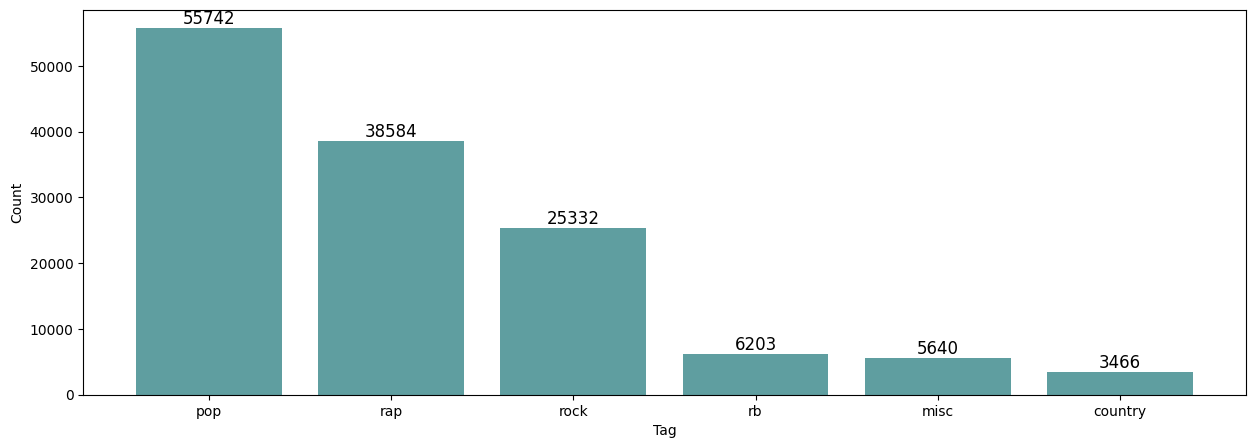

In [23]:
plot_bar_chart(train, 'tag', 'Tag', annotate = True)

### `title`

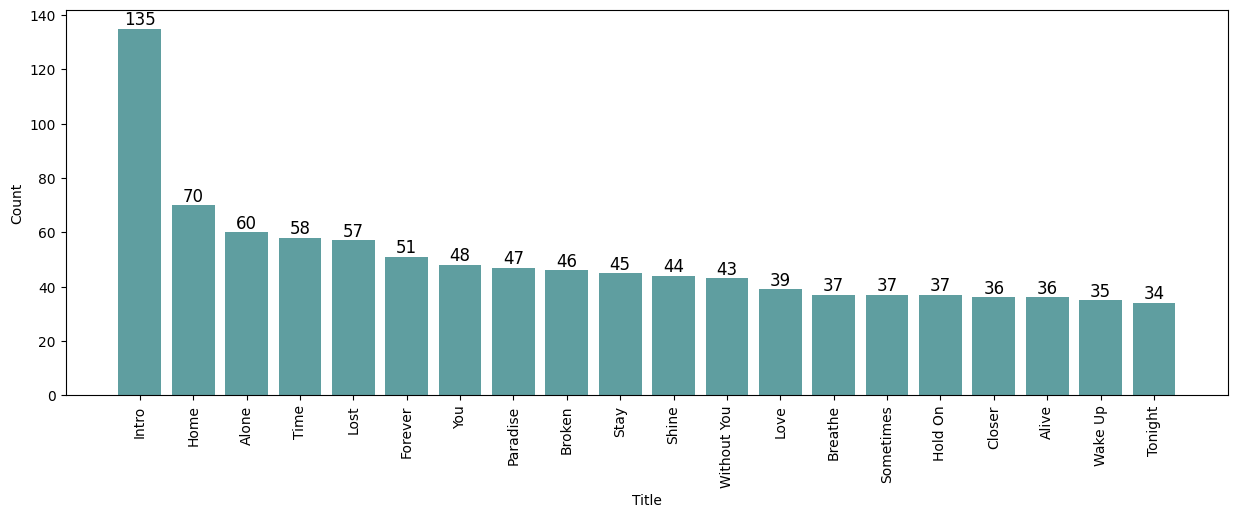

In [24]:
plot_bar_chart(train, 'title', 'Title', annotate=True, top=20, vertical=True)

### `artist`

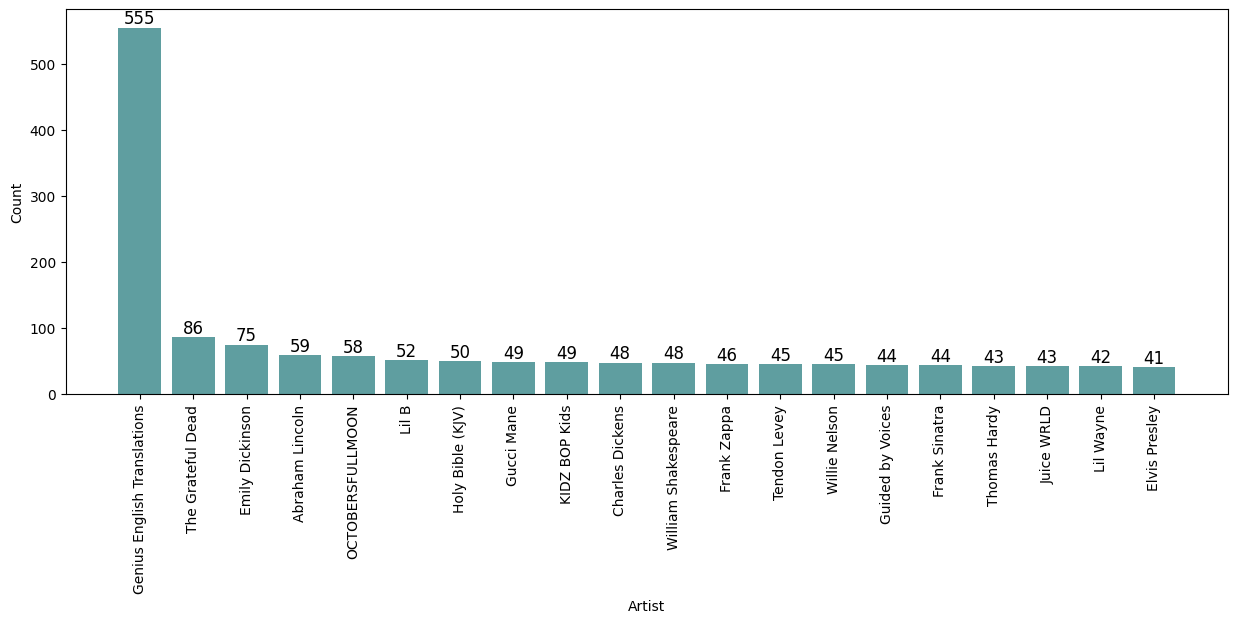

In [25]:
plot_bar_chart(train, 'artist', 'Artist', annotate = True, top=20, vertical=True)

### `features`

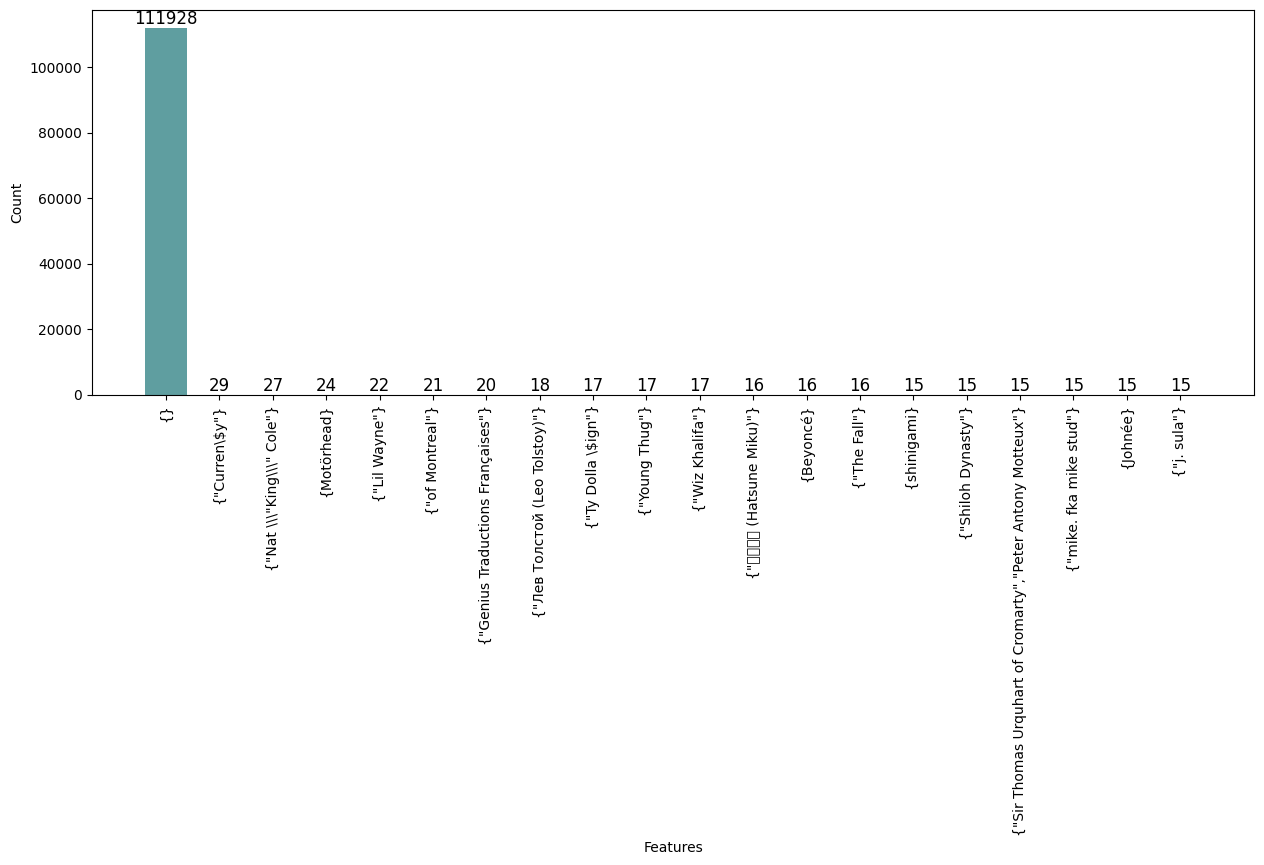

In [26]:
plot_bar_chart(train, 'features', 'Features', annotate=True, top=20, vertical=True)

In [27]:
# Features that contains the word "Genius"
train[train['features'].str.contains('Genius')]['features'].value_counts()

features
{"Genius Traductions Françaises"}                                 20
{"Polskie tłumaczenia Genius"}                                    11
{"Genius Brasil Traduções"}                                        9
{"Tattoo Genius"}                                                  2
{Bilal,"Anna Wise",Thundercat,"Genius Traductions Françaises"}     1
{"MisUnderstood Genius","Vanesza JT"}                              1
{"Genius Farsi Translations (ترجمه‌ی فارسی)"}                      1
{"Education Genius"}                                               1
{"News Genius",Hypothes.is,IndieWebCamp}                           1
{Genius}                                                           1
{"Genius Internationals"}                                          1
{"Genius Türkçe Çeviri"}                                           1
{"Genius Lists"}                                                   1
{"John Hamilton","Sports Genius Basketball"}                       1
{"Rap Genius Editors"}   

### `year`

In [28]:
train[train['year'] > 2023]

,title,tag,artist,year,views,features,lyrics
id,,,,,,,
7680512,STRAIGHT FIRE like the oven,rock,Whoops!,2024,52,"{Morgan,Roope,Barnes}",(Yeah LFG on that beat)\n(G-Gamzee Productions...


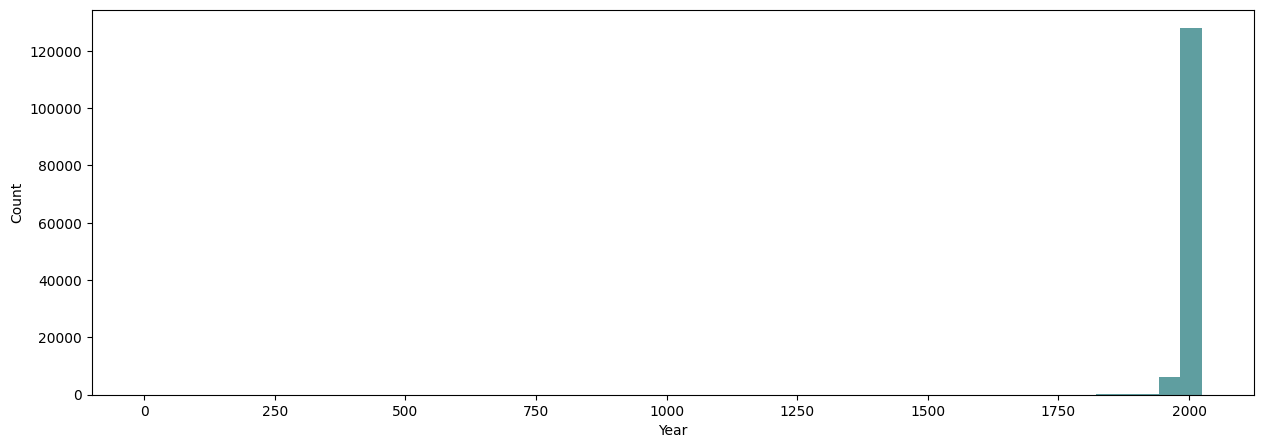

In [29]:
plot_histogram(train, 'year', 'Year')

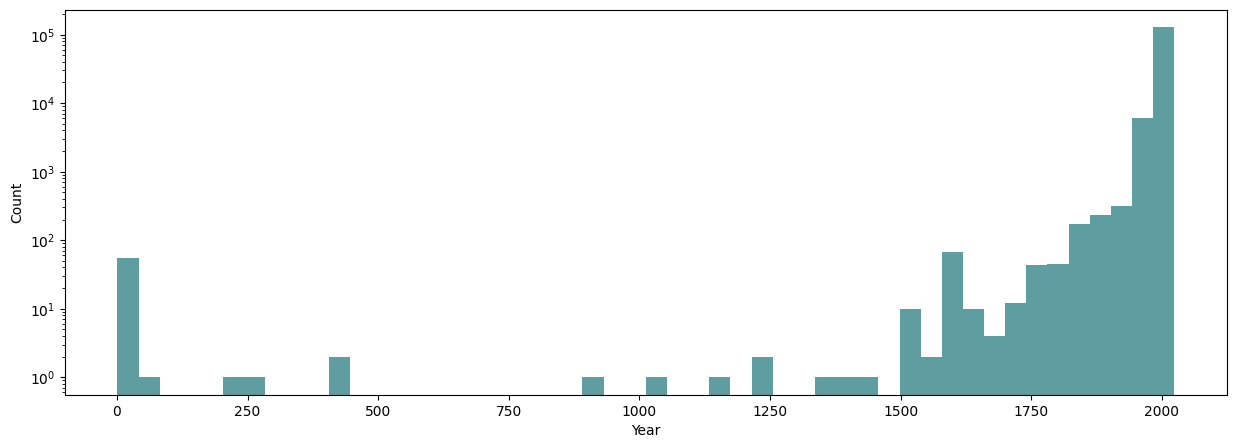

In [30]:
plot_histogram(train, 'year', 'Year', log=True)

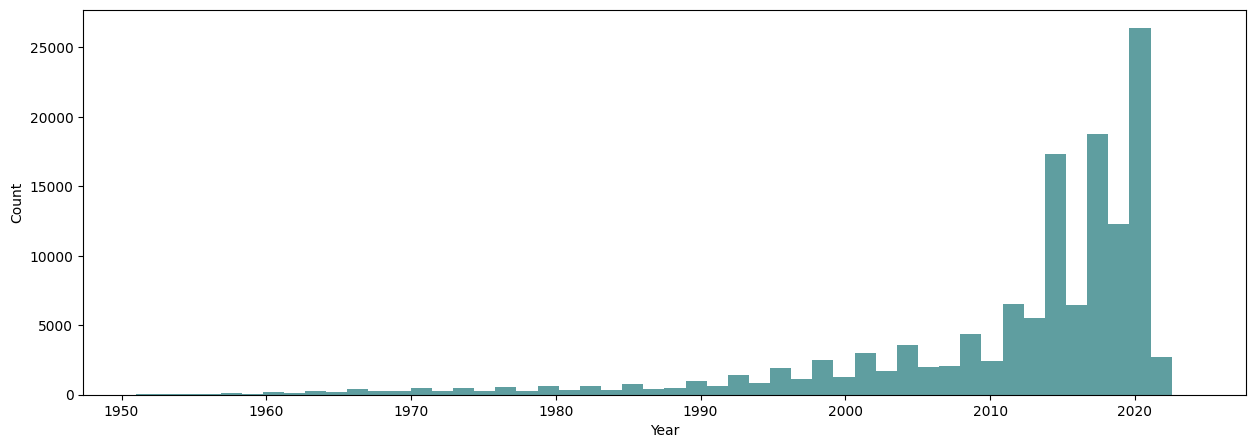

In [31]:
train_o1950 = train[train['year'] > 1950].copy()

plot_histogram(train_o1950, 'year', 'Year')

### `views`

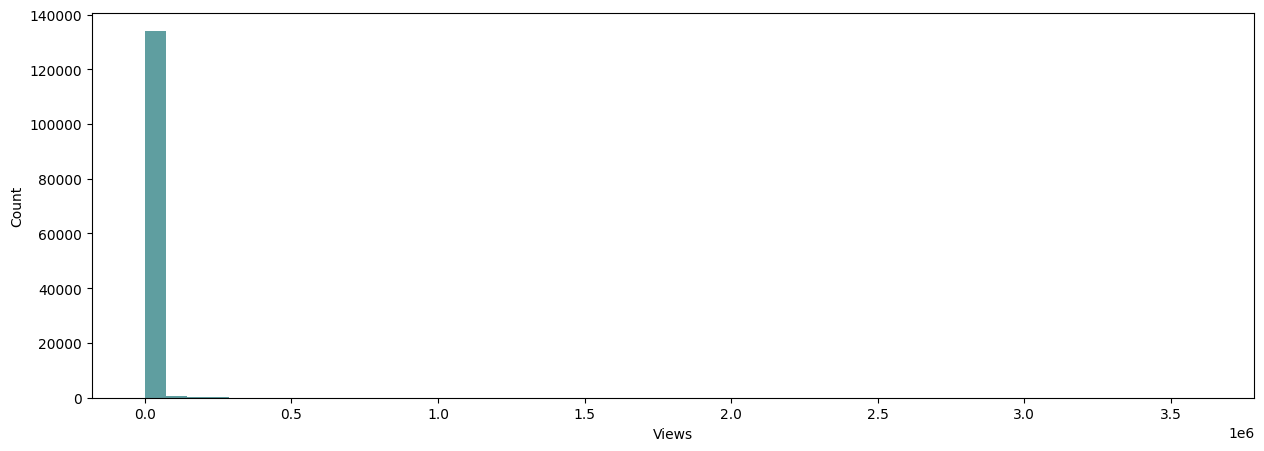

In [32]:
plot_histogram(train, 'views', 'Views')

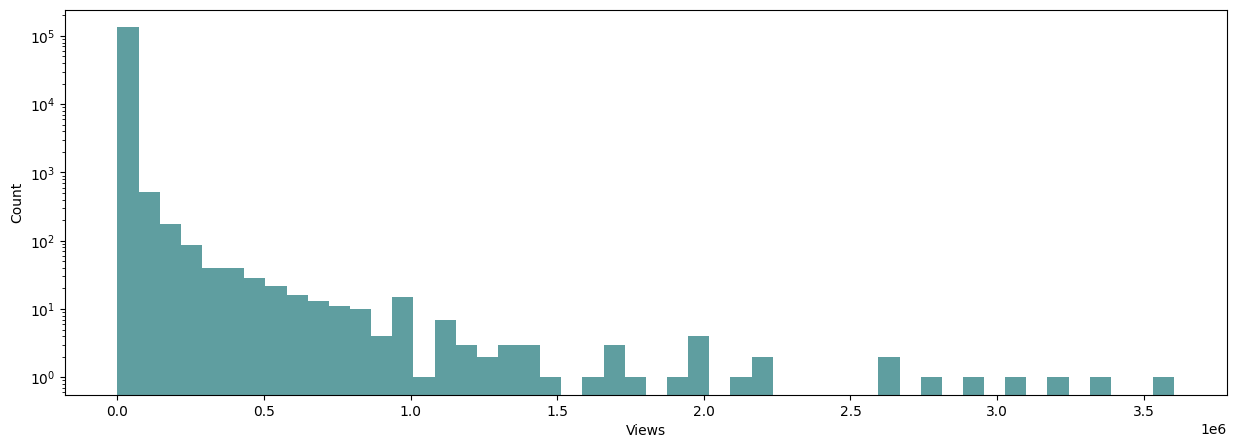

In [33]:
plot_histogram(train, 'views', 'Views', log=True)

### Data Examination
<a id='data-examination'></a>

Percentage of lyrics, which already includes the title

In [4]:
# Initialize a counter variable
count = 0

# Iterate through each row in the 'train' DataFrame
for index, row in train.iterrows():
    # Retrieve the 'title' and 'lyrics' columns from the current row
    title = row['title']
    lyrics = row['lyrics']

    # Check if both 'title' and 'lyrics' are strings to avoid potential errors
    if isinstance(title, str) and isinstance(lyrics, str):
        # Check if the lowercase 'title' string is contained within the lowercase 'lyrics' string
        if title.lower() in lyrics.lower():
            # Increment the counter if the 'title' is found within 'lyrics'
            count += 1

# Calculate the percentage of lyrics that already include the title
percentage = int(100 * count / len(train))

# Print the percentage of lyrics that contain their corresponding title
print('Percentage of lyrics, which already includes the title: {}%'.format(percentage))

Percentage of lyrics, which already includes the title: 54%


### Text Preprocessing
<a id='preproc'></a>

* [For Classification](#class)
* [For Sentiment Analysis](#sent-analys)

#### For Classification
<a id='class'></a>

* [Duplicated Lyrics](#dup-lyrics)
* [Inter Dataset](#inter-dataset)
* [Log Ratio](#log-ratio1)
* [Approaches words comparision](#comp)
* [Vectorization](#vec)

In [5]:
# Text preprocessing
lyrics_train  = text_preprocessing(train, 'lyrics', 'tag')
lyrics_test = text_preprocessing(test, 'lyrics')

##### Duplicated Lyrics
<a id='dup-lyrics'></a>

In [36]:
# Duplicate lyrics in training set
lyrics_train[lyrics_train['lyrics'].duplicated()] #248

,lyrics,tag
id,,
1631672,if you could see me now you would know how blu...,pop
875992,my heart be sad and lonely for you i sigh for ...,rb
1987068,somewhere over the rainbow way up high there b...,pop
1728585,out of nowhere you come from a little dust and...,pop
2205183,i will let it burn word in a dirty paper cup a...,pop
...,...,...
2339574,verse 1 i be seven year old when i get my firs...,rap
859758,every time i close my eye i hide behind the bl...,pop
707184,so i speak and the beautiful goddess straightw...,misc


In [6]:
# Drop duplicated lyrics in training set
lyrics_train.drop_duplicates(subset=['lyrics'], inplace=True)

##### Inter-Dataset
<a id='inter-dataset'></a>

In [38]:
# Lyrics in the training set that are in the test set
lyrics_train[lyrics_train['lyrics'].isin(lyrics_test['lyrics'])] #111

,lyrics,tag
id,,
1175388,have yourself a merry little christmas let you...,pop
3017305,assignment 4 step 10 annotation 1 highlight th...,misc
179716,iii leave your home behind lad and reach your ...,misc
131909,shizzy sixx suicune sixx bring flame again uni...,rap
1377280,do not be frighten when you be with me they ca...,pop
...,...,...
961450,can not say i do not know what i be doin and i...,pop
4885231,verse 1 lose your way lose your cool then you ...,pop
1363919,i will never let you see the way my break hear...,pop


In [7]:
# Drop inter-dataset observations
lyrics_in_both = lyrics_train[lyrics_train['lyrics'].isin(lyrics_test['lyrics'])]
lyrics_train.drop(lyrics_in_both.index, inplace=True)

#### Log Ratio
<a id='log-ratio1'></a>

In [8]:
# Percentage of genres in the dataset
genre_percents, genre_percents_dict = genre_percentages(lyrics_train)

In [9]:
# Frequency of genres in the dataset
genre_freqs, genre_freqs_inverted, overall_freq = genre_frequencies(lyrics_train, genre_percents, genre_percents_dict)

In [10]:
# Top words
top_words = log_ratio(genre_freqs, genre_percents, total_words=3000)

# Top words with inverted order
# top_words_inverted = log_ratio(genre_freqs_inverted, genre_percents, total_words=3000)

# Top words by genre
for genre, words in top_words.items():
    print(f'Top words for {genre}: {words}')

# print('\n')

# # Top words inverted by genre
# for genre, words in top_words_inverted.items():
#     print(f'Top words for {genre}: {words}')

Top words for pop: [('lezenvia', 1.2124114010869154), ('tico', 1.2124114010869151), ('thoia', 1.2124114010869151), ('yahdee', 1.2124114010869151), ('trika', 1.2124114010869151), ('lna', 1.2124114010869151), ('vrm', 1.2124114010869151), ('gec', 1.2124114010869151), ('odl', 1.2124114010869151), ('yiggy', 1.2124114010869151), ('bicyclette', 1.2124114010869151), ('whyne', 1.2124114010869151), ('boogly', 1.2124114010869151), ('sokah', 1.2124114010869151), ('djesse', 1.2124114010869151), ('dairaan', 1.2124114010869151), ('giggy', 1.200065565264616), ('tennant', 1.196411059740474), ('mabeline', 1.196411059740474), ('wiggy', 1.1962820191570316), ('relivin', 1.1958820991357049), ('namo', 1.1954618427731418), ('chugga', 1.194392895584237), ('bimba', 1.1933632061162207), ('heya', 1.1875654025003841), ('dinosaurchestra', 1.1806627027723349), ('slaton', 1.1739451202591191), ('woho', 1.173190687933634), ('cuerpo', 1.1724060664732159), ('uhu', 1.1724060664732159), ('tuk', 1.1682865961779771), ('dequa

In [11]:
# Words considered Relevant by Log Ratio
relevant_words = [word for sublist in top_words.values() for word, _ in sublist]

# Words considered Relevant by Log Ratio in inverted order
# relevant_words_inverted = [word for sublist in top_words_inverted.values() for word, _ in sublist]

In [12]:
word_set = set(relevant_words) # convert list to set for faster lookup

lyrics_train['lyrics_filtered'] = lyrics_train['lyrics'].apply(lambda x: filter_lyrics(x, word_set))

##### Word Cloud
<a id='word-cloud'></a>

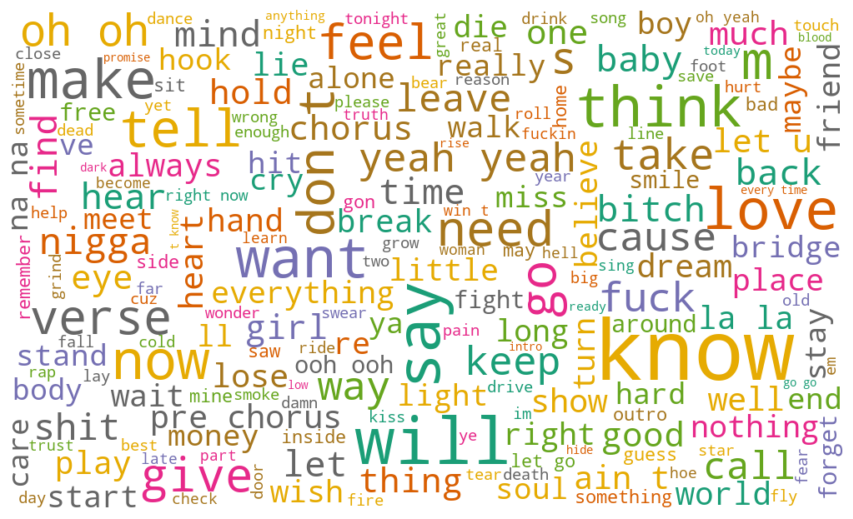

In [ ]:
# Join the preprocessed sentences into a single string
wordcloud_input = ' '.join(lyrics_train['lyrics_filtered'])

# Create a wordcloud
wordcloud = WordCloud(width=1000, height=600, 
                background_color='white', 
                max_font_size=100, 
                colormap='Dark2').generate(wordcloud_input)

# Plot the WordCloud image
plt.figure(facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

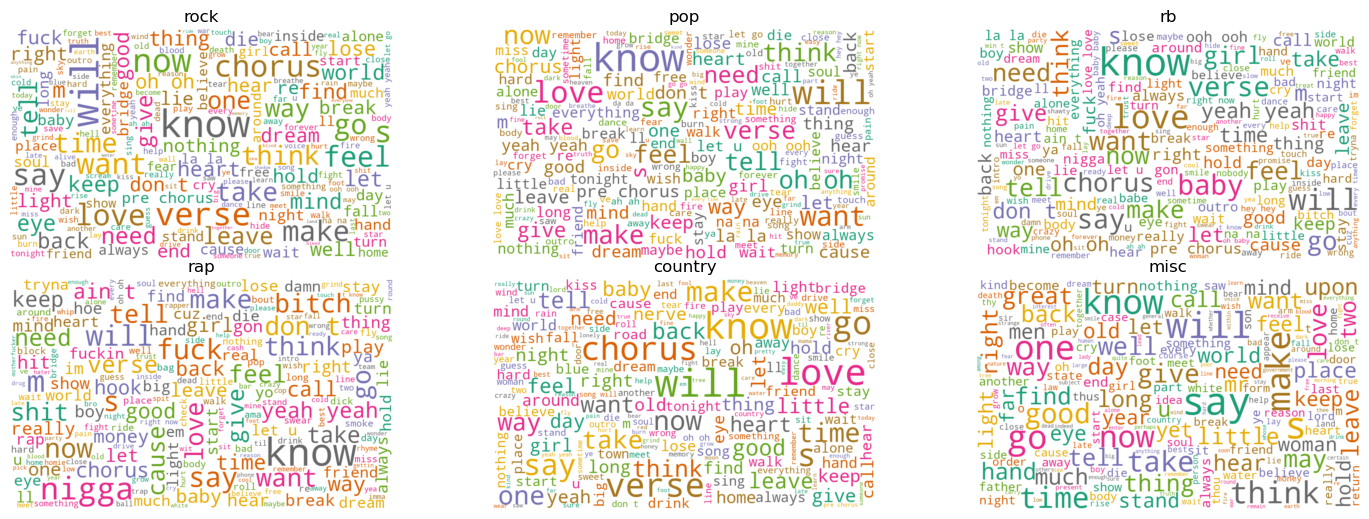

In [ ]:
# Unique tags
unique_tags = lyrics_train['tag'].unique()

# Create a mapping between tags and subplot positions
tag_positions = {tag: i for i, tag in enumerate(unique_tags)}

# Define subplot grid dimensions based on the number of unique tags
num_tags = len(unique_tags)
cols = num_tags // 2 + num_tags % 2  # Number of columns based on 2 rows
fig, ax = plt.subplots(2, cols)

for tag in unique_tags:
    wordcloud_input = ' '.join(lyrics_train.loc[lyrics_train['tag'] == tag, 'lyrics_filtered'])
    wordcloud = WordCloud(width=1000, height=600, 
                    background_color='white', 
                    max_font_size=100, 
                    colormap='Dark2').generate(wordcloud_input)
    position = tag_positions[tag]
    row = position % 2  # Calculate row index
    col = position // 2   # Calculate column index
    ax[row, col].imshow(wordcloud, interpolation='bilinear')
    ax[row, col].axis('off')
    ax[row, col].set_title(tag)

# # Hide any empty subplots if the number of tags doesn't fill the entire grid
# for i in range(num_tags, cols * 2):
#     ax.flatten()[i].axis('off')

plt.tight_layout(pad=0)
plt.show()

#### Approaches words comparision
<a id='comp'></a>

In [45]:
# count = 0
# for word in relevant_words:
#     if word not in relevant_words_inverted:
#         print(word)
#         count += 1

# count

immortal
prevail
butch
flag
hero
rattle
skeleton
seed
swell
pattern
inner
giant
tongue
creature
gasp
defeat
silent
become
conscience
scatter
revolution
warrior
ruin
feed
seal
core
forest
harvest
amend
divide
shape
knockin
righteous
universe
knee
scent
vain
human
repent
th
psycho
tower
pave
confession
perish
teeth
mass
slumber
hunt
web
grey
limp
reputation
monster
exist
crush
sleepy
reality
blade
defend
insane
dimension
choice
review
totally
weep
reaction
strife
bliss
dignity
sight
danny
sympathy
fist
remain
dwell
crystal
haven
pain
stone
hall
cunt
twist
innocent
consequence
grief
distraction
stake
ghost
mistake
retreat
truth
pile
numb
gasoline
distress
arrow
self
thief
lazy
century
ultimate
stain
reflect
bear
honesty
virgin
tennessee
circle
prisoner
slave
seek
pawn
flee
fiction
weight
metal
disgust
lead
throne
alley
quest
thought
layer
starve
abuse
rail
say
stay
goin
club
fix
bless
side
how
ha
bad
really
ma
x2
myself
ll
party
everyday
m
think
i
about
play
both
keep
what
much
when
shoul

216

#### Vectorization
<a id='vec'></a>

* [Bag of Words](#bow)
* [One Hot Encoding](#oh-enc)
* [TF-IDF](#tf-idf)

##### Bag of Words
<a id='bow'></a>

In [48]:
# train_bow = count_vectorizer_to_df(lyrics_train['lyrics'], relevant_words)
# test_bow = count_vectorizer_to_df(lyrics_test['lyrics'], relevant_words)

# partial_X_train_bow, X_val_bow, partial_y_train_bow, y_val_bow = train_test_split(train_bow, lyrics_train['tag'],
#                                                                                 stratify=lyrics_train['tag'], shuffle=True,
#                                                                                 test_size=0.2, random_state=21)

In [49]:
# partial_X_train_bow_st, X_val_bow_st = data_transform(StandardScaler(), partial_X_train_bow, X_val_bow)
# partial_X_train_bow_mm, X_val_bow_mm = data_transform(MinMaxScaler(), partial_X_train_bow, X_val_bow)
# partial_X_train_bow_rb, X_val_bow_rb = data_transform(RobustScaler(), partial_X_train_bow, X_val_bow)

##### One Hot Encoding
<a id='oh-enc'></a>

In [52]:
train_oh = oh_count_vectorizer_to_df(lyrics_train['lyrics'], relevant_words)
test_oh = oh_count_vectorizer_to_df(lyrics_test['lyrics'], relevant_words)

partial_X_train_oh, X_val_oh, partial_y_train_oh, y_val_oh = train_test_split(train_oh, lyrics_train['tag'],
                                                                             stratify=lyrics_train['tag'], shuffle=True,
                                                                             test_size=0.2, random_state=21)

In [53]:
# train_oh_inverted = oh_count_vectorizer_to_df(lyrics_train['lyrics'], relevant_words_inverted)
# test_oh_inverted = oh_count_vectorizer_to_df(lyrics_test['lyrics'], relevant_words_inverted)

# partial_X_train_oh_inverted, X_val_oh_inverted, partial_y_train_oh_inverted, y_val_oh_inverted = train_test_split(train_oh_inverted, lyrics_train['tag'],
#                                                                                                                         stratify=lyrics_train['tag'], shuffle=True,
#                                                                                                                         test_size=0.2, random_state=21)

##### TF-IDF
<a id='tf-idf'></a>

In [54]:
# train_tfidf = tf_idf_to_df(lyrics_train['lyrics'])
# test_tfidfl = tf_idf_to_df(lyrics_test['lyrics'])

# partial_X_train_tfidf, X_val_tfidf, partial_y_train_tfidf, y_val_tfidf = train_test_split(train_tfidf, lyrics_train['tag'],
#                                                                                           stratify=lyrics_train['tag'], shuffle=True,
#                                                                                           test_size=0.2, random_state=21)

#### For Sentiment Analysis
<a id='sent-analys'></a>

* [Stopwords Polarity](#stp-pol)
* [Log Ratio](#log-ratio2)

#### Stopwords Polarity
<a id='stp-pol'></a>

In [13]:
# List of stopwrds
stopwords = nltk.corpus.stopwords.words('english')
# stopwords

In [14]:
# Initialize Vader algorithm to check stopwords polarity
vader = SentimentIntensityAnalyzer()

In [15]:
# stopwords polarity
sent_compound_list = []

for word in stopwords:
    sent_compound_list.append(vader.polarity_scores(word)["compound"])

polarity = np.array(sent_compound_list).mean()
polarity

0.0015413407821229048

As observed in the classification section, stopwords have a significant impact on the most common and relevant words. <br>
Furthermore, given their neutral polarity mean, we have decided not considered them for further analysis.

In [16]:
# text preprocessing for sentiment analysis
# exclude stopwords, and include emojis
preproc_with_emojis = text_preprocessing(train, 'lyrics', 'tag', apply_stopwords_removal=True, emojis_removal=False)

# exclude stopwords and emojis
preproc_without_emojis = text_preprocessing(train, 'lyrics', 'tag', apply_stopwords_removal=True, emojis_removal=True)

#### Log Ratio
<a id='log-ratio2'></a>

* [With Emojis](#yes-emj)
* [Without Emojis](#no-emj)

##### With Emojis
<a id='yes-emj'></a>

In [ ]:
# Percentage of genres in the dataset
genre_percentages_with_emojis, genre_percentages_with_emojis_dict = genre_percentages(preproc_with_emojis)

In [ ]:
# Frequency of genres in the dataset
genre_freqs_with_emojis, genre_freqs_inverted_with_emojis, overall_freq_with_emojis = genre_frequencies(preproc_with_emojis, genre_percentages_with_emojis, genre_percentages_with_emojis_dict)

In [ ]:
# Top words
top_words_with_emojis = log_ratio(genre_freqs_with_emojis, genre_percentages_with_emojis, total_words=2000)

# Top words by genre
# # Print top words for each genre
# for genre, words in top_words_with_emojis.items():
#     print(f'Top words for {genre}: {words}')

In [ ]:
# Words considered Relevant by Log Ratio
relevant_words_with_emojis = [word for sublist in top_words_with_emojis.values() for word, _ in sublist]

# Words considered Common by Log Ratio
most_common_words_with_emojis = [pair[0] for pair in overall_freq_with_emojis.most_common(2000)]

# common_words_not_chosen = [word for word in most_common_words if word not in relevant_words]
# words_to_use = relevant_words + common_words_not_chosen

##### Without Emojis
<a id='no-emj'></a>

In [ ]:
# Percentage of genres in the dataset
genre_percentages_without_emojis, genre_percentages_without_emojis_dict = genre_percentages(preproc_without_emojis)

In [ ]:
# Frequency of genres in the dataset
genre_freqs_without_emojis, genre_freqs_inverted_without_emojis, overall_freq_without_emojis = genre_frequencies(preproc_without_emojis, genre_percentages_without_emojis, genre_percentages_without_emojis_dict)

In [ ]:
# Top words
top_words_without_emojis = log_ratio(genre_freqs_without_emojis, genre_percentages_without_emojis, total_words=2000)

# Top words by genre
# # Print top words for each genre
# for genre, words in top_words_without_emojis.items():
#     print(f'Top words for {genre}: {words}')

In [ ]:
# Words considered Relevant by Log Ratio
relevant_words_without_emojis = [word for sublist in top_words_without_emojis.values() for word, _ in sublist]

# Words considered Common by Log Ratio
most_common_words_without_emojis = [pair[0] for pair in overall_freq_without_emojis.most_common(2000)]
# common_words_not_chosen = [word for word in most_common_words if word not in relevant_words]
# words_to_use = relevant_words + common_words_not_chosen

In [67]:
# display(genre_percentages_with_emojis == genre_percentages_without_emojis)                            # True
# display(genre_percentages_with_emojis_dict == genre_percentages_without_emojis_dict)                  # False
# display(genre_freqs_with_emojis == genre_freqs_without_emojis)                                        # False
# display(genre_freqs_inverted_with_emojis == genre_freqs_inverted_without_emojis)                      # False
# display(overall_freq_with_emojis == overall_freq_without_emojis)                                      # False
# display(top_words_with_emojis == top_words_without_emojis)                                            # False
# display(top_words_inverted_with_emojis == top_words_inverted_without_emojis)                          # False
# display(relevant_words_with_emojis == relevant_words_without_emojis)                                  # False
# display(relevant_words_inverted_with_emojis == relevant_words_inverted_without_emojis)                # False
# display(most_common_words_with_emojis == most_common_words_without_emojis)                            # True

## **Modeling**
<a id='model'></a>

1. [Logistic Regression](#logr)
2. [Naive-Bayes](#nb)
3. [XGBoost](#xgb)
4. [Neural-Network](#nn)
5. [Comparisons](#comparison-models)

### Logistic Regression
<a id='logr'></a>

In [ ]:
# logr = LogisticRegression(multi_class='multinomial')

# logr_parameters = {
#     'penalty': ['l1', 'l2', 'elasticnet', None],
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], #'liblinear' (not for multiclass)
#     'class_weight': [None, 'balanced'],
# }

In [ ]:
# This cell was run with a previous word selection
# It was later confirmed that the output is the same as the one obtained with the current word selection
# grid_search(logr, logr_parameters, X_train_oh, y_train_oh)

Fitting 2 folds for each of 160 candidates, totalling 320 fits
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.3s
[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.4s
[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.4s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time= 2.4min
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time= 2.5min
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   8.2s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   8.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=  15.8s
[CV] END C=0.01, class_weight=None

In [ ]:
# best_logr = LogisticRegression(C=0.1,
#                                class_weight=None, #default
#                                multi_class='multinomial', #same
#                                penalty='l2', #default
#                                solver='saga')

In [ ]:
# logr_train_score, logr_val_score = model_evaluation(best_logr, partial_X_train_oh, X_val_oh, partial_y_train_oh, y_val_oh)

TRAINING
Weighted F1-score: 67.65%

               precision    recall  f1-score   support

     country       0.63      0.20      0.30      2766
        misc       0.86      0.49      0.62      4476
         pop       0.63      0.86      0.73     44387
         rap       0.88      0.87      0.88     30864
          rb       0.56      0.17      0.27      4957
        rock       0.60      0.33      0.43     20236

    accuracy                           0.70    107686
   macro avg       0.69      0.49      0.54    107686
weighted avg       0.70      0.70      0.68    107686


VALIDATON
Weighted F1-score: 65.01%

               precision    recall  f1-score   support

     country       0.47      0.14      0.21       691
        misc       0.80      0.44      0.57      1119
         pop       0.61      0.84      0.71     11097
         rap       0.87      0.86      0.86      7716
          rb       0.44      0.12      0.19      1240
        rock       0.54      0.31      0.39      5059

 

#### Number of words selection

In [ ]:
# This loop tells the best number of words to use
# The output has to be used to update the word selection

# best_number_of_words = 0
# best_score = 0

# for i in range(1000, 5001, 100):
#     top_words_loop = log_ratio(genre_freqs, genre_percentages, total_words=i)
#     relevant_words_loop = [word for sublist in top_words_loop.values() for word, _ in sublist]

#     train_oh_loop = oh_count_vectorizer_to_df(lyrics_train['lyrics'], relevant_words_loop)

#     partial_X_train_oh_loop, X_val_oh_loop, partial_y_train_oh_loop, y_val_oh_loop = train_test_split(train_oh_loop, lyrics_train['tag'],
#                                                                                                       stratify=lyrics_train['tag'], shuffle=True,
#                                                                                                       test_size=0.2, random_state=21)
    
#     logr.fit(partial_X_train_oh_loop, partial_y_train_oh_loop)
#     score = f1_score(y_val_oh_loop, logr.predict(X_val_oh_loop), average='weighted')
#     if score > best_score:
#         best_score = score
#         best_number_of_words = i

# print(f'The best number of words is {best_number_of_words} with a weighted f1-score of {round(100*best_score, 2)}% in validation set.')

The best number of words is 3000 with a weighted f1-score of 65.1% in validation set.


### Naive-Bayes
<a id='nb'></a>

In [ ]:
# nb = MultinomialNB()

# nb_parameters = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
#     'fit_prior': [True, False]
# }

In [ ]:
# grid_search(nb, nb_parameters, train_oh, lyrics_train['tag'])

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ........................alpha=0.001, fit_prior=True; total time=  10.3s
[CV] END ........................alpha=0.001, fit_prior=True; total time=   9.1s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   8.5s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   8.0s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   8.3s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   8.4s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   8.1s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   8.7s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   8.6s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   8.3s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   8.1s
[CV] END .........................alpha=0.1, fit

In [ ]:
# best_nb = MultinomialNB(alpha=10, fit_prior=True)

In [ ]:
# nb_train_score, nb_val_score = model_evaluation(best_nb, partial_X_train_oh, X_val_oh, partial_y_train_oh, y_val_oh)

TRAINING
Weighted F1-score: 62.21%

               precision    recall  f1-score   support

     country       0.29      0.15      0.19      2766
        misc       0.52      0.52      0.52      4476
         pop       0.62      0.67      0.64     44387
         rap       0.86      0.78      0.82     30864
          rb       0.25      0.34      0.29      4957
        rock       0.45      0.42      0.44     20236

    accuracy                           0.62    107686
   macro avg       0.50      0.48      0.48    107686
weighted avg       0.63      0.62      0.62    107686


VALIDATON
Weighted F1-score: 61.36%

               precision    recall  f1-score   support

     country       0.23      0.12      0.16       691
        misc       0.51      0.52      0.51      1119
         pop       0.61      0.66      0.63     11097
         rap       0.86      0.78      0.82      7716
          rb       0.25      0.33      0.28      1240
        rock       0.44      0.40      0.42      5059

 

### XGBoost
<a id='xgb'></a>

In [ ]:
# # Initialize the XGBoost classifier
# xgb = XGBClassifier(objective='multi:softmax', num_class=6)  # Set the appropriate parameters

# # Define the parameter grid
# xgb_parameters = {
#     'learning_rate': [0.001, 0.01, 0.1, 1],
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [3, 5, 7, 10, 12],
#     'min_child_weight': [1, 3, 5, 7, 10, 12],
# }

In [ ]:
# y_dict = {
#     'country': 0,
#     'misc': 1,
#     'pop': 2,
#     'rap': 3,
#     'rb': 4,
#     'rock': 5
# }

# partial_y_train_oh_map = partial_y_train_oh.map(y_dict)
# y_val_oh_map = y_val_oh.map(y_dict)

In [ ]:
# Unfortunately, the code was run again and the output was not saved
# However, the outputed parameters are the ones refered in the cell below
# grid_search(xgb, xgb_parameters, train_oh, lyrics_train['tag'].map(y_dict))

In [ ]:
# best_xgb = XGBClassifier(objective='multi:softmax', num_class=6,
#                          learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=500)

In [ ]:
# xgb_train_score, xgb_val_score = model_evaluation(best_xgb, partial_X_train_oh, X_val_oh, partial_y_train_oh_map, y_val_oh_map)

TRAINING
Weighted F1-score: 80.71%

               precision    recall  f1-score   support

           0       0.97      0.46      0.63      2766
           1       0.97      0.63      0.76      4476
           2       0.72      0.95      0.82     44387
           3       0.95      0.94      0.94     30864
           4       0.96      0.50      0.66      4957
           5       0.86      0.50      0.64     20236

    accuracy                           0.82    107686
   macro avg       0.91      0.66      0.74    107686
weighted avg       0.84      0.82      0.81    107686


VALIDATON
Weighted F1-score: 64.85%

               precision    recall  f1-score   support

           0       0.48      0.10      0.16       691
           1       0.82      0.45      0.58      1119
           2       0.61      0.85      0.71     11097
           3       0.86      0.88      0.87      7716
           4       0.45      0.09      0.15      1240
           5       0.55      0.29      0.38      5059

 

### Neural-Network
<a id='nn'></a>

In [ ]:
# Instantiate the tuner
# tuner = kt.Hyperband(build_model, # the hypermodel
#                      objective='val_loss',  # Our main monitoring metric
#                      max_epochs=50,  # Number of epochs
#                      factor=3,  # Reduction factor for the number of epochs and number of models for each bracket
#                      directory='c:\\Users\\Afonso Cadete\\Documents\\GitHub\\Text-Mining-Project',
#                      project_name='hyperband_tuning'  # Name of the directory to save the results
# )

In [ ]:
# Display search space summary
# tuner.search_space_summary()

Search space summary
Default search space size: 5
dense_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': 'linear'}
l2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.001, 'step': 0.0005, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# Encode the target variable
partial_y_train_oh_encoded = pd.Categorical(partial_y_train_oh).codes
y_val_oh_encoded = pd.Categorical(y_val_oh).codes

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Perform the hyperparameter search
# tuner.search(partial_X_train_oh, partial_y_train_oh_encoded, epochs=100, validation_data=(X_val_oh, y_val_oh_encoded), callbacks=[early_stop])

Trial 90 Complete [00h 02m 35s]
val_loss: 0.8308402895927429

Best val_loss So Far: 0.8209089636802673
Total elapsed time: 01h 24m 25s


In [ ]:
# Perform the hyperparameter search
# tuner.search(partial_X_train_oh, partial_y_train_oh_encoded, epochs=100, validation_data=(X_val_oh, y_val_oh_encoded), callbacks=[early_stop])

In [ ]:
# Get the optimal hyperparameters
# tuner.get_best_hyperparameters()[0].values

# IMPORTANT:
# The model provided by the hyperparameter search was not used
# Because, it had too much overfitting
# So, the model was tuned manually

{'dense_num_layers': 2,
 'dense_units_1': 140,
 'l2': 0.0,
 'dropout_1': 0.0,
 'learning_rate': 0.001,
 'dense_units_2': 100,
 'dropout_2': 0.1,
 'dense_units_3': 180,
 'dropout_3': 0.0,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
nn = Sequential()
nn.add(Dense(100, input_dim=len(relevant_words), activation='relu', kernel_regularizer=keras.regularizers.l2(0.0002)))
nn.add(Dense(6, activation='softmax'))

nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               300200    
                                                                 
 dense_11 (Dense)            (None, 6)                 606       
                                                                 
Total params: 300806 (1.15 MB)
Trainable params: 300806 (1.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
nn_train_score, nn_val_score = model_evaluation_nn(nn, partial_X_train_oh, X_val_oh, 
                                                   partial_y_train_oh_encoded, y_val_oh_encoded,
                                                   callbacks=[early_stop]
                                                   )

Epoch 1/100
22/22 [==============================] - 2s 68ms/step - loss: 1.2699 - accuracy: 0.5873 - val_loss: 1.0429 - val_accuracy: 0.6518
Epoch 2/100
22/22 [==============================] - 1s 57ms/step - loss: 0.9865 - accuracy: 0.6643 - val_loss: 0.9551 - val_accuracy: 0.6692
Epoch 3/100
22/22 [==============================] - 1s 52ms/step - loss: 0.9191 - accuracy: 0.6773 - val_loss: 0.9198 - val_accuracy: 0.6736
Epoch 4/100
22/22 [==============================] - 1s 50ms/step - loss: 0.8839 - accuracy: 0.6833 - val_loss: 0.9017 - val_accuracy: 0.6758
Epoch 5/100
22/22 [==============================] - 1s 47ms/step - loss: 0.8610 - accuracy: 0.6887 - val_loss: 0.8889 - val_accuracy: 0.6782
Epoch 6/100
22/22 [==============================] - 1s 46ms/step - loss: 0.8448 - accuracy: 0.6918 - val_loss: 0.8815 - val_accuracy: 0.6788
Epoch 7/100
22/22 [==============================] - 1s 45ms/step - loss: 0.8327 - accuracy: 0.6957 - val_loss: 0.8762 - val_accuracy: 0.6800
Epoch 

842/842 [==============================] - 1s 1ms/step


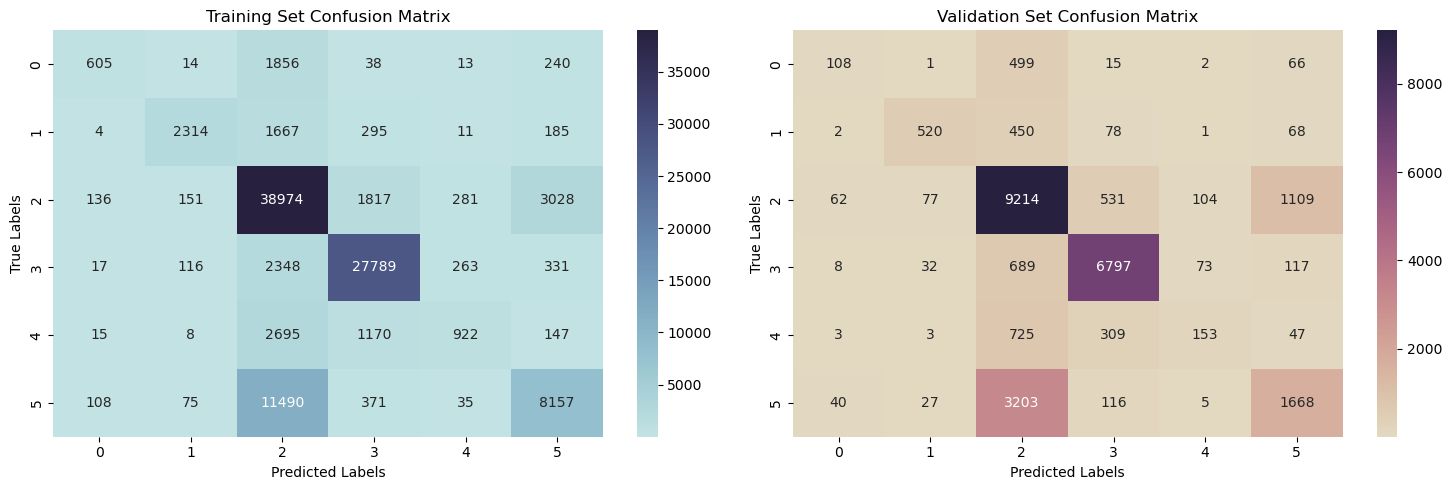

In [ ]:
# Assuming you already have confusion matrices generated
# Replace these matrices with your actual confusion matrices
train_conf_matrix = confusion_matrix(partial_y_train_oh_encoded, np.argmax(nn.predict(partial_X_train_oh), axis=1))
val_conf_matrix = confusion_matrix(y_val_oh_encoded, np.argmax(nn.predict(X_val_oh), axis=1))

# Plotting the confusion matrix heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2)  # Creating subplots for train and validation matrices
plot_confusion_matrix(ax1, train_conf_matrix, 'Training Set', color_map=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plot_confusion_matrix(ax2, val_conf_matrix, 'Validation Set', color_map=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

plt.tight_layout()
plt.show()

### Comparisons
<a id='comparison-models'></a>

1. [Log-ratio words imputation order](#order-comparision)
2. [Vectorization technique](#vec-comparision)
3. [Models](#models-comparision)
4. [Kaggle Submission](#kaggle)

#### Log-ratio words imputation order
<a id='order-comparision'></a>

In [ ]:
# partial_y_train_oh_inverted_encoded = pd.Categorical(partial_y_train_oh_inverted).codes
# y_val_oh_inverted_encoded = pd.Categorical(y_val_oh_inverted).codes

In [ ]:
# nn_train_score_inverted, nn_val_score_inverted = model_evaluation_nn(nn, partial_X_train_oh_inverted, X_val_oh_inverted,
#                                                                      partial_y_train_oh_inverted_encoded, y_val_oh_inverted_encoded,
#                                                                      callbacks=[early_stop]
#                                                                      )

Epoch 1/100
22/22 [==============================] - 1s 50ms/step - loss: 1.3268 - accuracy: 0.5597 - val_loss: 1.0880 - val_accuracy: 0.6522
Epoch 2/100
22/22 [==============================] - 1s 47ms/step - loss: 1.0241 - accuracy: 0.6597 - val_loss: 0.9839 - val_accuracy: 0.6641
Epoch 3/100
22/22 [==============================] - 1s 48ms/step - loss: 0.9453 - accuracy: 0.6728 - val_loss: 0.9422 - val_accuracy: 0.6725
Epoch 4/100
22/22 [==============================] - 1s 45ms/step - loss: 0.9047 - accuracy: 0.6798 - val_loss: 0.9189 - val_accuracy: 0.6749
Epoch 5/100
22/22 [==============================] - 1s 44ms/step - loss: 0.8788 - accuracy: 0.6849 - val_loss: 0.9061 - val_accuracy: 0.6771
Epoch 6/100
22/22 [==============================] - 1s 46ms/step - loss: 0.8607 - accuracy: 0.6895 - val_loss: 0.8953 - val_accuracy: 0.6774
Epoch 7/100
22/22 [==============================] - 1s 44ms/step - loss: 0.8465 - accuracy: 0.6923 - val_loss: 0.8889 - val_accuracy: 0.6788
Epoch 

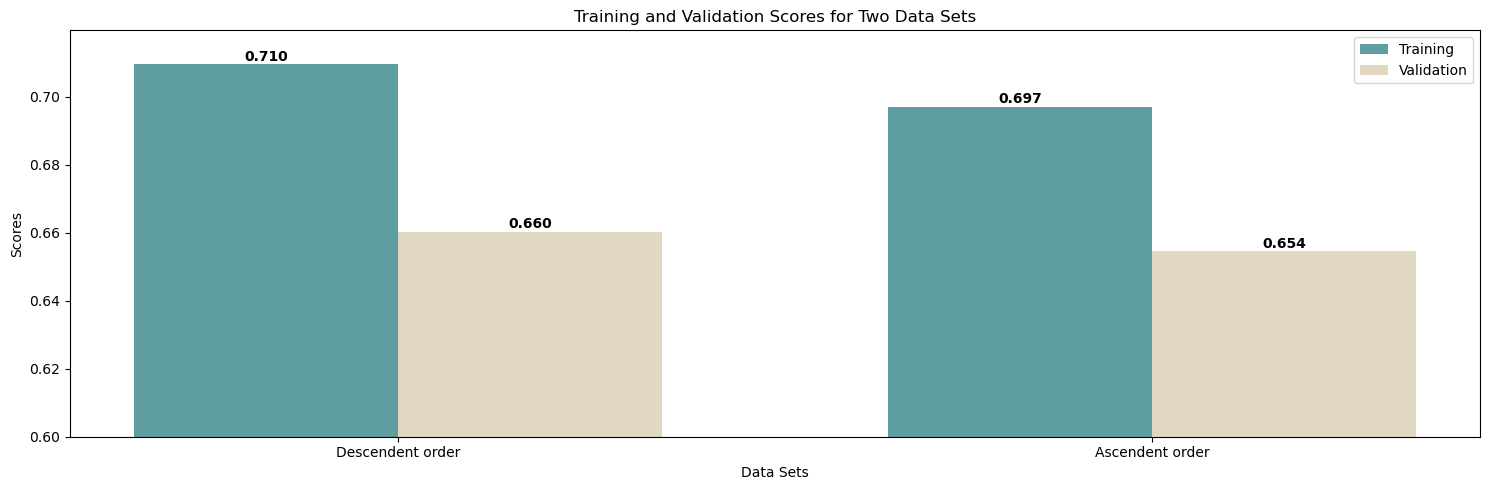

In [ ]:
# # Define the data
# train_scores = [nn_train_score, nn_train_score_inverted]
# val_scores = [nn_val_score, nn_val_score_inverted]

# # Set the width of the bars
# bar_width = 0.35

# # Set the positions of the bars on the x-axis
# r1 = np.arange(len(train_scores))
# r2 = [x + bar_width for x in r1]

# # Create the bar chart
# plt.bar(r1, train_scores, color='cadetblue', width=bar_width, label='Training')
# plt.bar(r2, val_scores, color='#E2D8C1', width=bar_width, label='Validation')

# # Annotate the values on each bar
# for i, score in enumerate(train_scores):
#     plt.text(i, score + 0.001, f'{score:.3f}', ha='center', color='black', fontweight='bold')
# for i, score in enumerate(val_scores):
#     plt.text(i + bar_width, score + 0.001, f'{score:.3f}', ha='center', color='black', fontweight='bold')

# # Add labels, title, and customizations
# plt.xlabel('Data Sets')
# plt.ylabel('Scores')
# plt.title('Training and Validation Scores for Two Data Sets')
# plt.xticks([r + bar_width / 2 for r in range(len(train_scores))], ['Descendent order', 'Ascendent order'])
# plt.ylim(0.6, max(max(train_scores), max(val_scores)) + 0.01)
# plt.legend()

# # Show plot
# plt.tight_layout()
# plt.show()


#### Vectorization technique
<a id='vec-comparision'></a>

In [ ]:
# partial_y_train_bow_encoded = pd.Categorical(partial_y_train_bow).codes
# y_val_bow_encoded = pd.Categorical(y_val_bow).codes

In [ ]:
# nn_train_score_bow, nn_val_score_bow = model_evaluation_nn(nn, partial_X_train_bow, X_val_bow,
#                                                             partial_y_train_bow_encoded, y_val_bow_encoded,
#                                                             callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 2s 55ms/step - loss: 1.3672 - accuracy: 0.5407 - val_loss: 1.1471 - val_accuracy: 0.6272
Epoch 2/100
22/22 [==============================] - 1s 48ms/step - loss: 1.0703 - accuracy: 0.6466 - val_loss: 1.0570 - val_accuracy: 0.6497
Epoch 3/100
22/22 [==============================] - 1s 46ms/step - loss: 0.9928 - accuracy: 0.6665 - val_loss: 1.0192 - val_accuracy: 0.6574
Epoch 4/100
22/22 [==============================] - 1s 43ms/step - loss: 0.9463 - accuracy: 0.6776 - val_loss: 0.9985 - val_accuracy: 0.6614
Epoch 5/100
22/22 [==============================] - 1s 43ms/step - loss: 0.9123 - accuracy: 0.6846 - val_loss: 0.9853 - val_accuracy: 0.6634
Epoch 6/100
22/22 [==============================] - 1s 46ms/step - loss: 0.8866 - accuracy: 0.6911 - val_loss: 0.9771 - val_accuracy: 0.6624
Epoch 7/100
22/22 [==============================] - 1s 46ms/step - loss: 0.8652 - accuracy: 0.6961 - val_loss: 0.9693 - val_accuracy: 0.6643
Epoch 

In [ ]:
# nn_train_score_bow_st, nn_val_score_bow_st = model_evaluation_nn(nn, partial_X_train_bow_st, X_val_bow_st,
#                                                                 partial_y_train_bow_encoded, y_val_bow_encoded,
#                                                                 callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 2s 54ms/step - loss: 1.4365 - accuracy: 0.5482 - val_loss: 1.2469 - val_accuracy: 0.6284
Epoch 2/100
22/22 [==============================] - 1s 52ms/step - loss: 0.9837 - accuracy: 0.6588 - val_loss: 1.1103 - val_accuracy: 0.6420
Epoch 3/100
22/22 [==============================] - 1s 49ms/step - loss: 0.8714 - accuracy: 0.6869 - val_loss: 1.0652 - val_accuracy: 0.6483
Epoch 4/100
22/22 [==============================] - 1s 49ms/step - loss: 0.8114 - accuracy: 0.7073 - val_loss: 1.0422 - val_accuracy: 0.6504
Epoch 5/100
22/22 [==============================] - 1s 56ms/step - loss: 0.7695 - accuracy: 0.7236 - val_loss: 1.0352 - val_accuracy: 0.6525
Epoch 6/100
22/22 [==============================] - 1s 59ms/step - loss: 0.7365 - accuracy: 0.7370 - val_loss: 1.0359 - val_accuracy: 0.6540
Epoch 7/100
22/22 [==============================] - 1s 57ms/step - loss: 0.7089 - accuracy: 0.7491 - val_loss: 1.0378 - val_accuracy: 0.6551
Epoch 

In [ ]:
# nn_train_score_bow_mm, nn_val_score_bow_mm = model_evaluation_nn(nn, partial_X_train_bow_mm, X_val_bow_mm,
#                                                                  partial_y_train_bow_encoded, y_val_bow_encoded,
#                                                                     callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 4s 152ms/step - loss: 1.7286 - accuracy: 0.5614 - val_loss: 1.6029 - val_accuracy: 0.6188
Epoch 2/100
22/22 [==============================] - 2s 71ms/step - loss: 1.5017 - accuracy: 0.6185 - val_loss: 1.3987 - val_accuracy: 0.6166
Epoch 3/100
22/22 [==============================] - 1s 64ms/step - loss: 1.3336 - accuracy: 0.6143 - val_loss: 1.2751 - val_accuracy: 0.6112
Epoch 4/100
22/22 [==============================] - 1s 61ms/step - loss: 1.2367 - accuracy: 0.6139 - val_loss: 1.2036 - val_accuracy: 0.6157
Epoch 5/100
22/22 [==============================] - 1s 54ms/step - loss: 1.1779 - accuracy: 0.6179 - val_loss: 1.1584 - val_accuracy: 0.6198
Epoch 6/100
22/22 [==============================] - 1s 51ms/step - loss: 1.1393 - accuracy: 0.6213 - val_loss: 1.1279 - val_accuracy: 0.6228
Epoch 7/100
22/22 [==============================] - 1s 56ms/step - loss: 1.1122 - accuracy: 0.6237 - val_loss: 1.1061 - val_accuracy: 0.6251
Epoch

In [ ]:
# nn_train_score_bow_rb, nn_val_score_bow_rb = model_evaluation_nn(nn, partial_X_train_bow_rb, X_val_bow_rb,
#                                                                     partial_y_train_bow_encoded, y_val_bow_encoded,
#                                                                     callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 5s 201ms/step - loss: 1.2900 - accuracy: 0.5716 - val_loss: 1.0968 - val_accuracy: 0.6436
Epoch 2/100
22/22 [==============================] - 1s 62ms/step - loss: 1.0179 - accuracy: 0.6592 - val_loss: 1.0121 - val_accuracy: 0.6583
Epoch 3/100
22/22 [==============================] - 1s 63ms/step - loss: 0.9423 - accuracy: 0.6735 - val_loss: 0.9786 - val_accuracy: 0.6609
Epoch 4/100
22/22 [==============================] - 2s 113ms/step - loss: 0.8987 - accuracy: 0.6833 - val_loss: 0.9621 - val_accuracy: 0.6616
Epoch 5/100
22/22 [==============================] - 1s 62ms/step - loss: 0.8687 - accuracy: 0.6928 - val_loss: 0.9521 - val_accuracy: 0.6647
Epoch 6/100
22/22 [==============================] - 1s 53ms/step - loss: 0.8447 - accuracy: 0.6997 - val_loss: 0.9470 - val_accuracy: 0.6656
Epoch 7/100
22/22 [==============================] - 1s 53ms/step - loss: 0.8248 - accuracy: 0.7066 - val_loss: 0.9431 - val_accuracy: 0.6678
Epoc

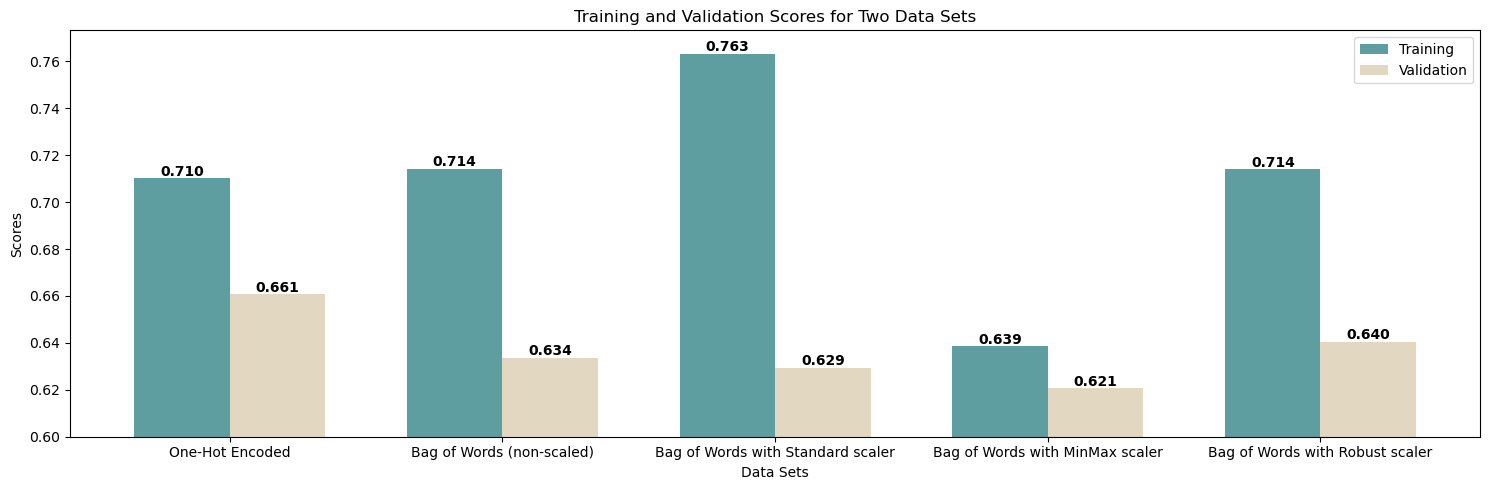

In [ ]:
# # Define the data
# train_scores = [nn_train_score, nn_train_score_bow, nn_train_score_bow_st, nn_train_score_bow_mm, nn_train_score_bow_rb]
# val_scores = [nn_val_score, nn_val_score_bow, nn_val_score_bow_st, nn_val_score_bow_mm, nn_val_score_bow_rb]

# # Set the width of the bars
# bar_width = 0.35

# # Set the positions of the bars on the x-axis
# r1 = np.arange(len(train_scores))
# r2 = [x + bar_width for x in r1]

# # Create the bar chart
# plt.bar(r1, train_scores, color='cadetblue', width=bar_width, label='Training')
# plt.bar(r2, val_scores, color='#E2D8C1', width=bar_width, label='Validation')

# # Annotate the values on each bar
# for i, score in enumerate(train_scores):
#     plt.text(i, score + 0.001, f'{score:.3f}', ha='center', color='black', fontweight='bold')
# for i, score in enumerate(val_scores):
#     plt.text(i + bar_width, score + 0.001, f'{score:.3f}', ha='center', color='black', fontweight='bold')

# # Add labels, title, and customizations
# plt.xlabel('Data Sets')
# plt.ylabel('Scores')
# plt.title('Training and Validation Scores for Two Data Sets')
# plt.xticks([r + bar_width / 2 for r in range(len(train_scores))], ['One-Hot Encoded', 'Bag of Words (non-scaled)', 'Bag of Words with Standard scaler', 'Bag of Words with MinMax scaler', 'Bag of Words with Robust scaler'])
# plt.ylim(0.6, max(max(train_scores), max(val_scores)) + 0.01)
# plt.legend()

# # Show plot
# plt.tight_layout()
# plt.show()

#### Models
<a id='models-comparision'></a>

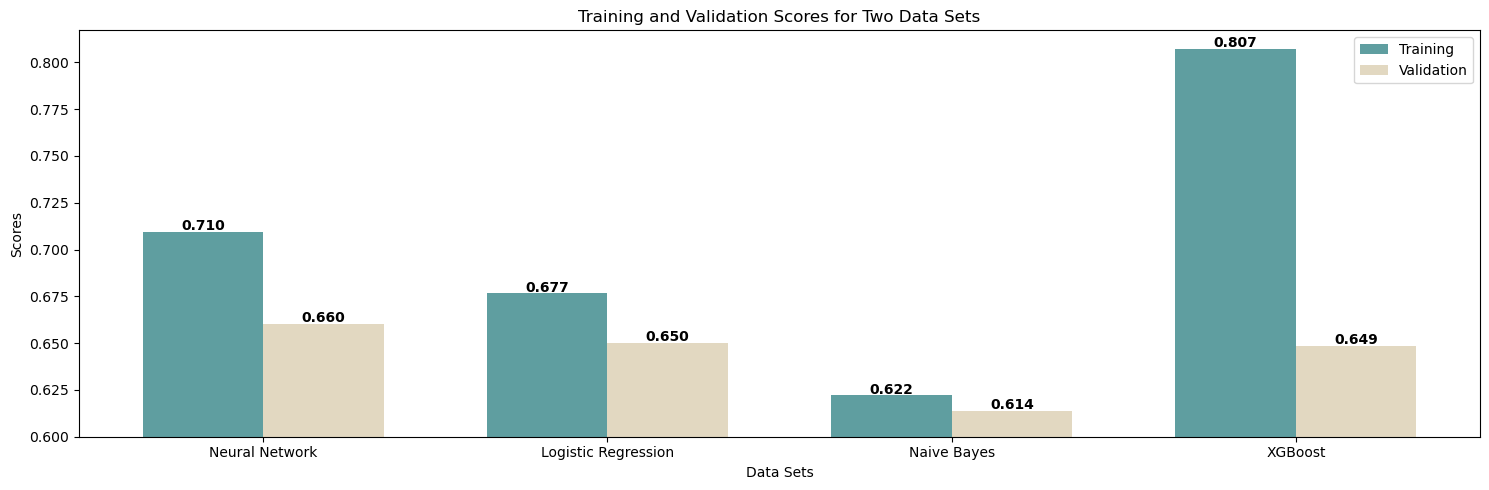

In [ ]:
# # Define the data
# train_scores = [nn_train_score, logr_train_score, nb_train_score, xgb_train_score]
# val_scores = [nn_val_score, logr_val_score, nb_val_score, xgb_val_score]

# # Set the width of the bars
# bar_width = 0.35

# # Set the positions of the bars on the x-axis
# r1 = np.arange(len(train_scores))
# r2 = [x + bar_width for x in r1]

# # Create the bar chart
# plt.bar(r1, train_scores, color='cadetblue', width=bar_width, label='Training')
# plt.bar(r2, val_scores, color='#E2D8C1', width=bar_width, label='Validation')

# # Annotate the values on each bar
# for i, score in enumerate(train_scores):
#     plt.text(i, score + 0.001, f'{score:.3f}', ha='center', color='black', fontweight='bold')
# for i, score in enumerate(val_scores):
#     plt.text(i + bar_width, score + 0.001, f'{score:.3f}', ha='center', color='black', fontweight='bold')

# # Add labels, title, and customizations
# plt.xlabel('Data Sets')
# plt.ylabel('Scores')
# plt.title('Training and Validation Scores for Two Data Sets')
# plt.xticks([r + bar_width / 2 for r in range(len(train_scores))], ['Neural Network', 'Logistic Regression', 'Naive Bayes', 'XGBoost'])
# plt.ylim(0.6, max(max(train_scores), max(val_scores)) + 0.01)
# plt.legend()

# # Show plot
# plt.tight_layout()
# plt.show()


### Kaggle Submission
<a id='kaggle'></a>

In [ ]:
cat = pd.Categorical(lyrics_train['tag'])

In [ ]:
nn.fit(train_oh, cat.codes, batch_size=5000, epochs=21, verbose=1)
predictions = nn.predict(test_oh)
predictions = np.argmax(predictions, axis=1)
submission = sample_submission.copy()
submission['tag'] = predictions
submission['tag'] = submission['tag'].apply(lambda x: cat.categories[x])

Epoch 1/21
27/27 [==============================] - 2s 56ms/step - loss: 1.2589 - accuracy: 0.5817
Epoch 2/21
27/27 [==============================] - 1s 53ms/step - loss: 0.9738 - accuracy: 0.6658
Epoch 3/21
27/27 [==============================] - 1s 47ms/step - loss: 0.9072 - accuracy: 0.6775
Epoch 4/21
27/27 [==============================] - 1s 44ms/step - loss: 0.8741 - accuracy: 0.6835
Epoch 5/21
27/27 [==============================] - 1s 42ms/step - loss: 0.8532 - accuracy: 0.6888
Epoch 6/21
27/27 [==============================] - 1s 40ms/step - loss: 0.8399 - accuracy: 0.6920
Epoch 7/21
27/27 [==============================] - 1s 40ms/step - loss: 0.8300 - accuracy: 0.6951
Epoch 8/21
27/27 [==============================] - 1s 40ms/step - loss: 0.8211 - accuracy: 0.6982
Epoch 9/21
27/27 [==============================] - 1s 39ms/step - loss: 0.8138 - accuracy: 0.7004
Epoch 10/21
27/27 [==============================] - 1s 39ms/step - loss: 0.8070 - accuracy: 0.7026
Epoch 11/

In [ ]:
# submission.to_csv(path + 'submissions\\Group06_Version09.csv')

## **Sentiment Analysis**
<a id='sa'></a>

1. [VADER Analysis](#vader)
2. [Text Blob Analysis](#text-blob)
3. [Exploration](#explore)

### VADER Analysis
<a id='vader'></a>

* [Dataset With Emojis](#emjis-df)
* [Dataset Without Emojis](#noemjis-df)
* [Comparisons between Datasets](#comp-df)

#### Dataset With Emojis
<a id='emojis-df'></a>

* [Lyrics with Relevant Words](#relevant-words)
* [Lyrics with Common Words](#common-words)
* [Lyrics with All Words](#all-words)
* [Comparisons between Words](#comp-words)

##### Lyrics with Relevant Words
<a id='relevant-words'></a>

In [ ]:
# Relevant set of words
relevant_words_set_with_emojis = set(relevant_words_with_emojis)

In [ ]:
# Vader with relevant words
emojis_relevant_df = vader_analysis(relevant_words_set_with_emojis, preproc_with_emojis)
emojis_relevant_df

In [ ]:
#### by genre
emojis_relevant_df_by_gender = polarity_by_gender(emojis_relevant_df)
emojis_relevant_df_by_gender

##### Lyrics with Common Words
<a id='common-words'></a>

In [ ]:
# Common set of words
common_words_set_with_emojis = set(most_common_words_with_emojis)

In [ ]:
# Vader with common words
emojis_common_df = vader_analysis(common_words_set_with_emojis, preproc_with_emojis)
emojis_common_df

In [ ]:
#### by genre
emojis_common_df_by_gender = polarity_by_gender(emojis_common_df)
emojis_common_df_by_gender

##### Lyrics with All Words
<a id='all-words'></a>

In [ ]:
# All words set
all_words_with_emojis = []

for lyric in preproc_with_emojis['lyrics']:
    for word in lyric.split(" "):
        all_words_with_emojis.append(word)

all_words_with_emojis = set(all_words_with_emojis)

In [ ]:
# Vader with all words
all_lyrics_with_emojis_df = vader_analysis(all_words_with_emojis, preproc_with_emojis)
all_lyrics_with_emojis_df

In [ ]:
#### by genre
all_lyrics_with_emojis_df_by_gender = polarity_by_gender(all_lyrics_with_emojis_df)
all_lyrics_with_emojis_df_by_gender

##### Comparisons between Words
<a id='comp-words'></a>

Relevant vs Common vs All words

In [ ]:
dataframes = [emojis_relevant_df_by_gender, emojis_common_df_by_gender, all_lyrics_with_emojis_df_by_gender]
titles = ['Relevant', 'Common', 'All words']

sentiment_differences_across_genres(dataframes, titles)

#### Dataset Without Emojis
<a id='noemojis-df'></a>

* [Lyrics with Relevant Words](#relevant-words2)
* [Lyrics with Common Words](#common-words2)
* [Lyrics with All Words](#all-words2)
* [Comparisons between Words](#comp2)

##### Lyrics with Relevant Words
<a id='relevant-words2'></a>

In [ ]:
### Relevant set of words
relevant_words_set_without_emojis = set(relevant_words_without_emojis)

In [ ]:
# Vader with relevant words
relevant_df = vader_analysis(relevant_words_without_emojis, preproc_without_emojis)
relevant_df

In [ ]:
#### by genre
relevant_df_by_gender = polarity_by_gender(relevant_df)
relevant_df_by_gender

##### Lyrics with Common Words
<a id='common-words2'></a>

In [ ]:
### Common set of words
common_words_set_without_emojis = set(most_common_words_without_emojis)

In [ ]:
# Vader with common words
common_df = vader_analysis(common_words_set_without_emojis, preproc_without_emojis)
common_df

In [ ]:
#### by genre
common_df_by_gender = polarity_by_gender(common_df)
common_df_by_gender

##### Lyrics with All Words
<a id='all-words2'></a>

In [ ]:
# All words set
all_words_without_emojis = []

for lyric in preproc_without_emojis['lyrics']:
    for word in lyric.split(" "):
        all_words_without_emojis.append(word)

all_words_without_emojis = set(all_words_without_emojis)

In [ ]:
# Vader with all words
all_lyrics_without_emojis_df = vader_analysis(all_words_without_emojis, preproc_without_emojis)
all_lyrics_without_emojis_df

In [ ]:
#### by genre
all_lyrics_without_emojis_df_by_gender = polarity_by_gender(all_lyrics_without_emojis_df)
all_lyrics_without_emojis_df_by_gender

##### Comparisons between Words
<a id='comp2'></a>

Relevant vs Common vs All words

In [ ]:
dataframes = [relevant_df_by_gender, common_df_by_gender, all_lyrics_without_emojis_df_by_gender]
titles = ['Relevant', 'Common', 'All words']

sentiment_differences_across_genres(dataframes, titles)

#### Comparisons between Datasets
<a id='comp-df'></a>

With Lyrics with All Words

In [ ]:
dataframes = [all_lyrics_with_emojis_df_by_gender, all_lyrics_without_emojis_df_by_gender]
titles = ['With Emojis', 'Without Emojis']

sentiment_differences_across_genres(dataframes, titles)

### Text Blob Analysis
<a id='text-blob'></a>

Given that Vader does not consider emojis relevant, and considering its effectiveness with them compared to TextBlob, which performs less optimally, we have chosen to analyze the dataset using TextBlob without including emojis.

#### Dataset Without Emojis
<a id='noemojis-df'></a>

* [Lyrics with Relevant Words](#relevant-words3)
* [Lyrics with Common Words](#common-words3)
* [Lyrics with All Words](#all-words3)
* [Comparisons between Words](#comp3)
* [Comparisons between Genders](#comp4)

##### Lyrics with Relevant Words
<a id='relevant-words3'></a>

In [ ]:
# TextBlob with relevant words
relevant_df2 = textblob_analysis(relevant_words_set_without_emojis, preproc_without_emojis)
relevant_df2 

In [ ]:
#### by genre
relevant_df2_by_gender = polarity_by_gender(relevant_df2)
relevant_df2_by_gender

##### Lyrics with Common Words
<a id='common-words3'></a>

In [ ]:
# TextBlob with common words
common_df2 = textblob_analysis(common_words_set_without_emojis, preproc_without_emojis)
common_df2 

In [ ]:
#### by genre
common_df2_by_gender = polarity_by_gender(common_df2)
common_df2_by_gender

##### Lyrics with All Words
<a id='all-words3'></a>

In [ ]:
# TextBlob with all words
all_lyrics_without_emojis_df2 = textblob_analysis(all_words_without_emojis, preproc_without_emojis)
all_lyrics_without_emojis_df2

In [ ]:
#### by genre
all_lyrics_without_emojis_df_by_gender2 = polarity_by_gender(all_lyrics_without_emojis_df2)
all_lyrics_without_emojis_df_by_gender2

##### Comparisons between Words
<a id='comp3'></a>

Relevant vs Common vs All Words

In [ ]:
dataframes = [relevant_df2_by_gender, common_df2_by_gender, all_lyrics_without_emojis_df_by_gender2]
titles = ['Relevant', 'Common', 'All words']

sentiment_differences_across_genres(dataframes, titles)

After the analysis that we have reached until this point, we have concluded to utilize only the relevants words to continue.

##### Comparisons between Genres
<a id='comp4'></a>

With Relevant Words

In [ ]:
top_words = log_ratio(genre_freqs_without_emojis, None, total_words=3000, separate=True)

genre_word_lists = {}  # Dictionary to store words for each genre

for genre, words in top_words.items():
    genre_word_lists[genre] = [word[0] for word in words]

pop_relevant_words = genre_word_lists['pop']
rap_relevant_words = genre_word_lists['rap']
rock_relevant_words = genre_word_lists['rock']
country_relevant_words = genre_word_lists['country']
rb_relevant_words = genre_word_lists['rb']
misc_relevant_words = genre_word_lists['misc']

pop_df = vader_analysis(pop_relevant_words, preproc_without_emojis)
rap_df = vader_analysis(rap_relevant_words, preproc_without_emojis)
rock_df = vader_analysis(rock_relevant_words, preproc_without_emojis)
country_df = vader_analysis(country_relevant_words, preproc_without_emojis)
rb_df = vader_analysis(rb_relevant_words, preproc_without_emojis)
misc_df = vader_analysis(misc_relevant_words, preproc_without_emojis)


dfs = [pop_df, rock_df, rap_df, country_df, rb_df, misc_df]
genres_relevant_words = ['pop_relevant_words', 'rock_relevant_words', 'rap_relevant_words', 
                         'country_relevant_words', 'rb_relevant_words', 'misc_relevant_words']
polarity_df = pd.DataFrame()

for genre, df in zip(genres_relevant_words, dfs):
    polarity_df[genre] = df['polarity']

polarity_df['tag'] = dfs[0]['tag']

sns.pairplot(polarity_df, hue='tag', corner=True, plot_kws={'alpha': 0.2}, diag_kind='kde')

### Exploration
<a id='explore'></a>

* [Predominant Lyrics' Sentiments by Genre](#sent-genre)
* [Lyrics' Sentiments Changes over years by Genre](#sent-years)
* [Predominant Lyrics' Sentiments and Views](#sent-views)

In [ ]:
music_df = relevant_df.copy()
music_df[["year", "views"]] = train[["year", "views"]]

##### Predominant Lyrics' Sentiments by Genre
<a id='sent-genre'></a>

In [ ]:
# dictionary that contains each lyric scores for each emotion per genre
compound_dict = {}

for tag in music_df['tag'].unique():
    compound_dict[tag] = emotion_scores(music_df, "filtered_lyrics", "tag", tag)

In [ ]:
# count of the words in each emotion per genre
overall_emotion_scores_by_gender = {}

for key, value in compound_dict.items():
    emotion_counts = {}
    for d in value:
        for emotion, count in d.items():
            if emotion in emotion_counts:
                emotion_counts[emotion] += count
            else:
                emotion_counts[emotion] = count
    overall_emotion_scores_by_gender[key] = emotion_counts
    
print(overall_emotion_scores_by_gender)

In [ ]:
# top 1 emotion per genre
overall_max_emotion_by_gender = {}

for genre, value in compound_dict.items():
    emotion_counts = {}
    for d in value:
        for emotion, count in d.items():
            if emotion not in ['positive', 'negative']:
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + count

    if emotion_counts:  # Check if the dictionary is not empty
        max_emotion = max(emotion_counts, key=emotion_counts.get)
        overall_max_emotion_by_gender[genre] = max_emotion
    else:
        overall_max_emotion_by_gender[genre] = None

print(overall_max_emotion_by_gender)

In [ ]:
# top 3 emotion per genre
overall_top3_emotions_by_gender = {}

for genre, value in compound_dict.items():
    emotion_counts = {}
    for d in value:
        for emotion, count in d.items():
            if emotion not in ['positive', 'negative']:
                emotion_counts[emotion] = emotion_counts.get(emotion, 0) + count

    if emotion_counts:  # Check if the dictionary is not empty
        top3_emotions = sorted(emotion_counts, key=emotion_counts.get, reverse=True)[:3]
        overall_top3_emotions_by_gender[genre] = top3_emotions
    else:
        overall_top3_emotions_by_gender[genre] = []

print(overall_top3_emotions_by_gender)

##### Lyrics' Sentiments Changes over years by Genre
<a id='sent-years'></a>

In [ ]:
# divide years in ranges
music_df['year_range'] = music_df['year'].apply(get_year_range)

In [ ]:
# Order of Year Range
year_range_order = ["< 1500", "50s", "60s", "70s", "80s", "90s", "2000s", "2010s", "2020", "2021", "2022", "2023", "2024", "Unknown"]

# Convert 'year_range' to the specified order
music_df['year_range'] = pd.Categorical(music_df['year_range'], categories=year_range_order, ordered=True)

# Group by 'year_range' and 'tag'
# calculate the mean polarity for each
polarity_by_year_range_tag = music_df.groupby(['year_range', 'tag'])['polarity'].mean().unstack(fill_value=0)

sns.set_palette(["#5F9EA0", "#C1D5D7", "#44616E", "#E2D8C1", "#9C9696", "#28233B"])
fig, ax = plt.subplots(figsize=(12, 6))

for tag in music_df['tag'].unique():
    ax.plot(polarity_by_year_range_tag.index, polarity_by_year_range_tag[tag], label=tag)

ax.set_xlabel('Year Range')
ax.set_ylabel('Polarity')
ax.legend(title='Tag', bbox_to_anchor=(1, 1), loc='upper left')

plt.title('Polarity Over Year Ranges by Tag')
plt.show()

##### Predominant Lyrics' Sentiments and Views
<a id='sent-views'></a>

In [ ]:
# Correlation coefficient and p-value for polarity and views
correlation_coefficient, p_value = pearsonr(music_df['polarity'], music_df['views'])

print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Visualization
sns.scatterplot(x='views', y='polarity', data=music_df, palette = ["#5F9EA0"])
plt.title('Sentiment vs. Views')
plt.show()

In [ ]:
# Number of vies per sentiment
sns.boxplot(x='sentiment', y='views', data=music_df, palette=["#5F9EA0"], log_scale=True)
plt.xticks(rotation=45, ha='right')
plt.title('Views by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Views')
plt.show()